In [1]:
import pandas as pd
import numpy as np
import math
import json
# % matplotlib inline
import matplotlib.pyplot as plt
import datetime
from prepare_data import *

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

<IPython.core.display.Javascript object>

In [70]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [26]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# read in the json files

portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Prepare data

In [4]:
profile = process_profile(profile) 
portfolio = process_portfolio(portfolio)

c:\users\bryan\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Create a master dataset containing the following on a line by line basis:
- person (str) - customer id.
- offer_id (str) - id of offer received .
- offer_received_day (int) - days since the start of the study when the offer is received.
- offer_end_day (int) - days since the start of the study when the offer expires.
- offer_viewed (dummy) - whether the offer was viewed.
- offer_completed (dummy) - whether the offer was completed.
- offer_completed_day (int) - days since the start of the study when the offer is completed.
- transaction (int) - amount spent between the offer received day and the earlier of the offer expiry date and the offer completion date.
- offer_worked (dummy) - whether the offer worked.
- offer_type (str) - whether offer is informational, bogo or discount.
- reward (int) - reward that customer gets from the offer.
- difficulty (int) - amount that customer needs to spend for the offer.
- duration (int) - number of days that offer lasts before expiring.
- bogo (dummy) - whether offer is bogo.
- discount (dummy) - whether offer is discount. 
- informational (dummy) - whether offer is informational.
- gender_F (dummy) - whether gender is female. 
- gender_M (dummy) - whether gender is male.
- gender_O (dummy) - whether gender is other.
- web (dummy) - whether offer channel is web.
- email (dummy) - whether offer channel is email.
- mobile (dummy) - whether offer channel is mobile.
- social media (dummy) - whether offer channel is social media.
- age (int) - age of customer.
- income (int) - annual income of customer.
- membership_years (int) - duration of membership in years. 

In [5]:
merged_df = create_merged_df(transcript,profile, portfolio )

In [71]:
master_df = merged_df.copy()

<IPython.core.display.Javascript object>

In [72]:
master_df.loc[
    (master_df.offer_viewed == 1) & (master_df.offer_completed == 1), "offer_worked"
] = 1
master_df.loc[
    ~((master_df.offer_viewed == 1) & (master_df.offer_completed == 1)), "offer_worked"
] = 0

<IPython.core.display.Javascript object>

In [73]:
master_df.offer_worked.value_counts()

0.0    44287
1.0    22214
Name: offer_worked, dtype: int64

<IPython.core.display.Javascript object>

In [74]:
master_df = master_df.merge(
    portfolio[
        [
            "offer_id",
            "offer_type",
            "reward",
            "difficulty",
            "duration",
            "web",
            "email",
            "mobile",
            "social",
        ]
    ],
    "left",
    on="offer_id",
)
master_df = master_df.merge(
    profile[["gender", "age", "person", "income", "membership_years"]],
    "left",
    on="person",
)

<IPython.core.display.Javascript object>

In [75]:
## For those informational offeres, we consider the offer to work if it is viewed and customer spends money before offer ends
master_df.loc[(master_df.offer_type=="informational")&(master_df.transaction>0)&(master_df.offer_viewed==1), "offer_worked"]=1


<IPython.core.display.Javascript object>

In [76]:
# One hot encoding for offer type
offer_dummies = pd.get_dummies(master_df.offer_type)
master_df = pd.concat([master_df,offer_dummies],axis='columns')
# One hot encoding for gender
gender_dummies = pd.get_dummies(master_df.gender,prefix="gender")
master_df = pd.concat([master_df,gender_dummies],axis='columns')


<IPython.core.display.Javascript object>

In [77]:
master_df.head()

,person,offer_id,offer_received_day,offer_end_day,offer_viewed,offer_completed,offer_completed_day,transaction,offer_worked,offer_type,reward,difficulty,duration,web,email,mobile,social,gender,age,income,membership_years,bogo,discount,informational,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,7.0,10.0,1,0,NaN,22.16,1.0,informational,0,0,3,0,1,1,1,M,33,72000.0,4.561644,0,0,1,0,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,14.0,18.0,1,0,NaN,8.57,1.0,informational,0,0,4,1,1,1,0,M,33,72000.0,4.561644,0,0,1,0,1,0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,22.0,0,1,17.25,8.57,0.0,bogo,5,5,5,1,1,1,1,M,33,72000.0,4.561644,1,0,0,0,1,0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,31.0,0,1,22.00,14.11,0.0,discount,2,10,10,1,1,1,1,M,33,72000.0,4.561644,0,1,0,0,1,0
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,31.0,0,1,24.00,10.27,0.0,discount,2,10,7,1,1,1,0,M,33,72000.0,4.561644,0,1,0,0,1,0


<IPython.core.display.Javascript object>

### Data Exploration

#### profile data

<AxesSubplot:>

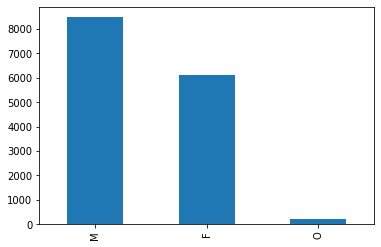

<IPython.core.display.Javascript object>

In [78]:
# Majority of customers are males
profile.gender.value_counts().plot(kind="bar")

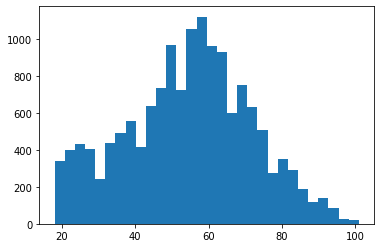

<IPython.core.display.Javascript object>

In [79]:
# Majority of customers between 50 to 60 years old
plt.hist(profile.age, bins=30)

In [80]:
# Mean age is 54 years old
profile.age.mean()

54.39352445193929

<IPython.core.display.Javascript object>

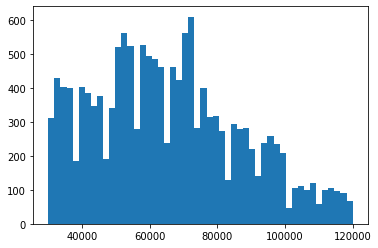

<IPython.core.display.Javascript object>

In [81]:
# Most people earn around 65k to 70k per year
plt.hist(profile.income, bins=50)

In [82]:
# Mean income is around $65000 per annum
profile.income.mean()

65404.9915682968

<IPython.core.display.Javascript object>

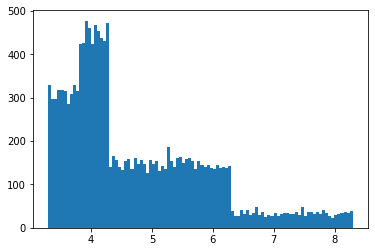

<IPython.core.display.Javascript object>

In [83]:
# Majority of customers have been around 4 years
plt.hist(profile.membership_years, bins=100)

In [84]:
profile.membership_years.mean()

4.730079419714015

<IPython.core.display.Javascript object>

#### master data

<AxesSubplot:xlabel='gender'>

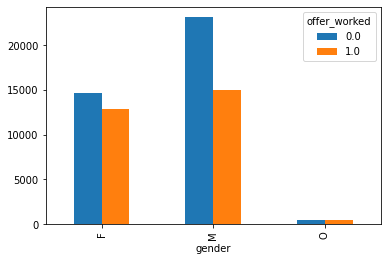

<IPython.core.display.Javascript object>

In [85]:
pd.crosstab(master_df.gender, master_df.offer_worked).plot(kind="bar")

Offers seems to be a good predictor of whether ofer worked. Offer is less likely to work on men compared to female and other

<AxesSubplot:xlabel='offer_type'>

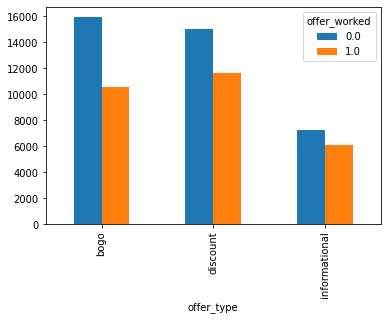

<IPython.core.display.Javascript object>

In [86]:
pd.crosstab(master_df.offer_type, master_df.offer_worked).plot(kind="bar")

Offer type seems to be good predictor of whether it will work or not. People respond quite well to informational offers.
People respond better to discounts than bogo.

In [204]:
master_df.groupby(["offer_worked"]).mean()

,offer_received_day,offer_end_day,offer_viewed,offer_completed,offer_completed_day,transaction,reward,difficulty,duration,web,email,mobile,social,age,income,membership_years,bogo,discount,informational,gender_F,gender_M,gender_O
offer_worked,,,,,,,,,,,,,,,,,,,,,,
0.0,13.920168,20.519068,0.423924,0.294883,16.838896,9.300838,4.417223,8.289334,6.598901,0.815914,1.0,0.857767,0.500955,53.682607,63724.512498,4.578158,0.417328,0.393744,0.188928,0.383170,0.605392,0.011438
1.0,13.775905,20.160164,1.000000,0.785058,16.170714,23.147741,3.903944,6.937588,6.384259,0.777601,1.0,0.954340,0.730245,55.296367,67595.525869,4.931482,0.374364,0.410694,0.214942,0.452962,0.530110,0.016928


<IPython.core.display.Javascript object>

- Those who viewed the offer are more likely to completely the offer.
- Offers are more likely to work for those that have been members for longer. 
- Offer has a higher chance of working for those that are older and have a higher income. 
- Offer will work more if on social media and mobile. 

In [88]:
master_df.corr()

,offer_received_day,offer_end_day,offer_viewed,offer_completed,offer_completed_day,transaction,offer_worked,reward,difficulty,duration,web,email,mobile,social,age,income,membership_years,bogo,discount,informational,gender_F,gender_M,gender_O
offer_received_day,1.000000,0.965555,-0.062515,0.051889,0.930366,0.025822,-0.008710,-0.000885,-0.003959,-0.003874,0.002758,NaN,0.003473,0.000317,0.001255,-0.000615,-0.000171,0.000624,-0.001149,0.000644,0.000217,0.000544,-0.003224
offer_end_day,0.965555,1.000000,-0.097613,0.146397,0.923467,0.032185,-0.020946,0.041288,0.206743,0.256457,0.091393,NaN,-0.134925,-0.048048,0.000393,-0.001221,0.000281,-0.047496,0.191796,-0.176848,-0.000900,0.001601,-0.002994
offer_viewed,-0.062515,-0.097613,1.000000,-0.011859,-0.039488,0.036126,0.605287,0.080143,-0.154093,-0.142921,-0.144685,NaN,0.268461,0.437937,0.005787,-0.007214,-0.003275,0.103864,-0.105329,0.001896,-0.015657,0.010214,0.022800
offer_completed,0.051889,0.146397,-0.011859,1.000000,NaN,0.194236,0.484715,0.222829,0.292826,0.369879,0.221269,NaN,-0.015539,0.092377,0.081845,0.182317,0.160176,0.147454,0.263570,-0.503458,0.125302,-0.127643,0.012344
offer_completed_day,0.930366,0.923467,-0.039488,NaN,1.000000,0.017308,-0.039488,-0.019875,0.047690,0.045789,0.009034,NaN,-0.049982,-0.048454,-0.002346,-0.014767,-0.014656,-0.037331,0.037331,NaN,-0.010089,0.013137,-0.012497
transaction,0.025822,0.032185,0.036126,0.194236,0.017308,1.000000,0.206124,0.005758,0.036548,0.027775,-0.009631,NaN,-0.043320,-0.003133,0.049163,0.134085,0.070362,-0.022941,0.020193,0.003344,0.063482,-0.063430,0.000998
offer_worked,-0.008710,-0.020946,0.605287,0.484715,-0.039488,0.206124,1.000000,-0.074682,-0.120474,-0.048141,-0.047322,NaN,0.158357,0.231263,0.045867,0.088512,0.152098,-0.043377,0.017099,0.032155,0.070085,-0.075256,0.023288
reward,-0.000885,0.041288,0.080143,0.222829,-0.019875,0.005758,-0.074682,1.000000,0.465176,0.161964,-0.120241,NaN,-0.079089,0.286961,-0.004319,0.001971,0.003557,0.791978,-0.287104,-0.617818,0.000306,0.000841,-0.004865
difficulty,-0.003959,0.206743,-0.154093,0.292826,0.047690,0.036548,-0.120474,0.465176,1.000000,0.809257,0.243572,NaN,-0.742892,-0.156460,-0.004088,-0.000858,0.001820,-0.031252,0.598690,-0.695277,-0.001124,0.001597,-0.002028
duration,-0.003874,0.256457,-0.142921,0.369879,0.045789,0.027775,-0.048141,0.161964,0.809257,1.000000,0.340997,NaN,-0.531442,-0.185837,-0.003150,-0.002406,0.001714,-0.184856,0.741376,-0.682049,-0.004266,0.004135,0.000472


<IPython.core.display.Javascript object>

To come up with features to predict whether an offer will work, based on above, we remove the following variables that are highly correlated to each other from the list of features:
- offer_received_day
- offer_end_day
- offer_completed_day
- transaction - this is removed because a large transaction amount likely means that the offer worked because customer is induced to spend more. We want to predict whether the offer will work based on the nature of the offer and demographic data, so transaction amount is removed from feature list. 

In [89]:
X = master_df[
    [
        "offer_viewed",
        "reward",
        "difficulty",
        "duration",
        "web",
        "email",
        "mobile",
        "social",
        "age",
        "income",
        "membership_years",
        "bogo",
        "discount",
        "informational",
        "gender_F",
        "gender_M",
        "gender_O",
    ]
]

<IPython.core.display.Javascript object>

In [90]:
y = master_df.offer_worked

<IPython.core.display.Javascript object>

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.5, random_state=7)


<IPython.core.display.Javascript object>

In [92]:
y_train_df = pd.DataFrame(y_train)

<IPython.core.display.Javascript object>

In [101]:
print(
    "Number of offer that did not work in training data: ",
    len(y_train_df[y_train_df["offer_worked"] == 0]),
)
print("Number of offer that worked: ", len(y_train_df[y_train_df["offer_worked"] == 1]))
print(
    "Proportion of offer did not work in training data is ",
    round((len(y_train_df[y_train_df["offer_worked"] == 0]) / len(y_train_df)), 2),
)
print(
    "Proportion of offer worked in training data is ",
    round(len(y_train_df[y_train_df["offer_worked"] == 1]) / len(y_train_df), 2),
)

Number of offer that did not work in training data:  19085
Number of offer that worked:  14165
Proportion of offer did not work in training data is  0.57
Proportion of offer worked in training data is  0.43


<IPython.core.display.Javascript object>

As above shows, the classes of offer worked response variable is balanced so there is no need for Synthetic Minority Over-sampling TEchnique (SMOTE).

### Modeling

#### Base model

In [103]:
model = LogisticRegression(solver="liblinear", random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Means close to 8 out of 10 observations are classified correctly
model.score(X_test, y_test)

0.7818411476346576

<IPython.core.display.Javascript object>

In [104]:
model.score(X_train, y_train)

0.7825263157894737

<IPython.core.display.Javascript object>

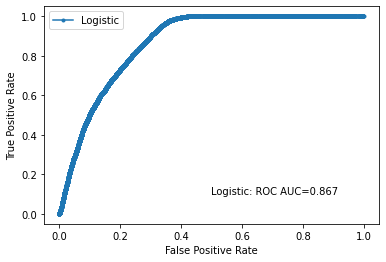

<IPython.core.display.Javascript object>

In [116]:
lr_probs = model.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
fpr, tpr, _ = roc_curve(y_test.values, lr_probs)

lr_auc = roc_auc_score(y_test, lr_probs)
text = "Logistic: ROC AUC=%.3f" % (lr_auc)
x_pos = 0.5
y_pos = 0.1
plt.text(x_pos, y_pos, text)
# plot the roc curve for the model
plt.plot(fpr, tpr, marker=".", label="Logistic")
# axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# show the legend
plt.legend()


# show the plot

plt.show()

In [117]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.71      0.79     19120
         1.0       0.69      0.88      0.77     14131

    accuracy                           0.78     33251
   macro avg       0.79      0.79      0.78     33251
weighted avg       0.80      0.78      0.78     33251



<IPython.core.display.Javascript object>

#### Base Model + Weaken Regularisation 

In [119]:
model = LogisticRegression(solver="liblinear", C=10, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Means close to 8 out of 10 obserations are classified correctly
model.score(X_test, y_test)

0.7820215933355388

<IPython.core.display.Javascript object>

In [120]:
model.score(X_train, y_train)

0.7827067669172932

<IPython.core.display.Javascript object>

Only a marginal improvement from Base Model

#### Base Model +  normalised data

In [123]:
# Normalizing continuous variables
scaler = MinMaxScaler(feature_range=(0, 1))

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

<IPython.core.display.Javascript object>

In [125]:
model = LogisticRegression(solver="liblinear", random_state=0)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

model.score(X_test_scaled, y_test)

0.7935701181919341

<IPython.core.display.Javascript object>

In [126]:
model.score(X_train_scaled, y_train)

0.7907669172932331

<IPython.core.display.Javascript object>

Accuracy improves by over 1%

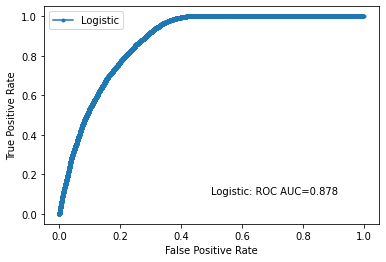

<IPython.core.display.Javascript object>

In [127]:
lr_probs = model.predict_proba(X_test_scaled)
lr_probs = lr_probs[:, 1]
fpr, tpr, _ = roc_curve(y_test.values, lr_probs)

lr_auc = roc_auc_score(y_test, lr_probs)
text = "Logistic: ROC AUC=%.3f" % (lr_auc)
x_pos = 0.5
y_pos = 0.1
plt.text(x_pos, y_pos, text)
# plot the roc curve for the model
plt.plot(fpr, tpr, marker=".", label="Logistic")
# axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# show the legend
plt.legend()
# show the plot
plt.show()

In [1072]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.74      0.80     19120
         1.0       0.71      0.87      0.78     14131

    accuracy                           0.79     33251
   macro avg       0.80      0.80      0.79     33251
weighted avg       0.81      0.79      0.79     33251



Accuracy, AUC, weighted average precision and recall and f1-score are higher after normalising data compared to baseline model

#### Random Forest Classifier

Without normalisation

In [151]:
clf = RandomForestClassifier(random_state=0)

<IPython.core.display.Javascript object>

In [152]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

<IPython.core.display.Javascript object>

In [153]:
y_pred = clf.predict(X_test)


<IPython.core.display.Javascript object>

In [154]:
clf.score(X_test, y_test)

0.806441911521458

<IPython.core.display.Javascript object>

In [155]:
clf.score(X_train, y_train)

0.9909172932330828

<IPython.core.display.Javascript object>

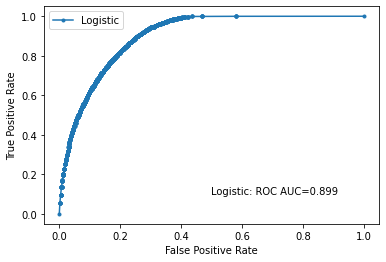

<IPython.core.display.Javascript object>

In [156]:
lr_probs = clf.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
fpr, tpr, _ = roc_curve(y_test.values, lr_probs)

lr_auc = roc_auc_score(y_test, lr_probs)
text = "Logistic: ROC AUC=%.3f" % (lr_auc)
x_pos = 0.5
y_pos = 0.1
plt.text(x_pos, y_pos, text)
# plot the roc curve for the model
plt.plot(fpr, tpr, marker=".", label="Logistic")
# axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# show the legend
plt.legend()
# show the plot
plt.show()

In [157]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83     19120
         1.0       0.76      0.79      0.78     14131

    accuracy                           0.81     33251
   macro avg       0.80      0.80      0.80     33251
weighted avg       0.81      0.81      0.81     33251



<IPython.core.display.Javascript object>

Even without hyperparameter tuning, Random Forest does better in test data than logistic regression. 

With normalisation

In [159]:
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=0)

<IPython.core.display.Javascript object>

In [160]:
clf.score(X_test_scaled, y_test)

0.8071636943249827

<IPython.core.display.Javascript object>

In [161]:
y_pred = clf.predict(X_test_scaled)


<IPython.core.display.Javascript object>

In [162]:
clf.score(X_train_scaled, y_train)

0.9909172932330828

<IPython.core.display.Javascript object>

In [200]:
feature_names = X_train.columns

<IPython.core.display.Javascript object>

In [201]:
features_importance_dict = dict(zip(feature_names, clf.feature_importances_))

<IPython.core.display.Javascript object>

In [202]:
# Sort according to most importance features
for i in list(
    sorted(features_importance_dict.items(), key=lambda x: x[1], reverse=True)
):
    print(i[0])

offer_viewed
membership_years
income
age
social
reward
duration
difficulty
gender_M
bogo
gender_F
mobile
discount
web
gender_O
informational
email


<IPython.core.display.Javascript object>

Random Forest + normalised data does marginally better than Random Forest + un-normalised data.

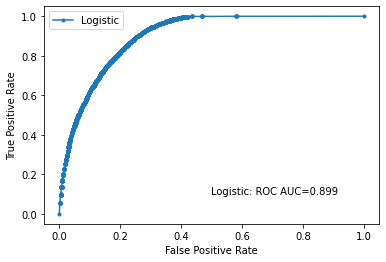

<IPython.core.display.Javascript object>

In [138]:
lr_probs = clf.predict_proba(X_test_scaled)
lr_probs = lr_probs[:, 1]
fpr, tpr, _ = roc_curve(y_test.values, lr_probs)

lr_auc = roc_auc_score(y_test, lr_probs)
text = "Logistic: ROC AUC=%.3f" % (lr_auc)
x_pos = 0.5
y_pos = 0.1
plt.text(x_pos, y_pos, text)
# plot the roc curve for the model
plt.plot(fpr, tpr, marker=".", label="Logistic")
# axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# show the legend
plt.legend()
# show the plot
plt.show()

In [139]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83     19120
         1.0       0.76      0.79      0.78     14131

    accuracy                           0.81     33251
   macro avg       0.80      0.81      0.80     33251
weighted avg       0.81      0.81      0.81     33251



<IPython.core.display.Javascript object>

Accuracy, AUC, weighted average recall and f1-score are higher for Random Forest + normalised data compared to Base Model + normalised data

#### GridsearchCV

In [140]:
params = {
    "clf__n_estimators": [100, 150, 200],
    "clf__criterion": ["gini", "entropy"],
    "clf__max_depth": [8, 10, 12],
    "clf__max_features": [5, 10],
}

<IPython.core.display.Javascript object>

In [141]:
pipeline = Pipeline(
    [("scaler", MinMaxScaler(feature_range=(0, 1))), ("clf", RandomForestClassifier())]
)

<IPython.core.display.Javascript object>

In [142]:
cv = GridSearchCV(pipeline, param_grid=params)

<IPython.core.display.Javascript object>

In [186]:
cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('clf', RandomForestClassifier())]),
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [8, 10, 12],
                         'clf__max_features': [5, 10],
                         'clf__n_estimators': [100, 150, 200]})

<IPython.core.display.Javascript object>

In [189]:
cv.score(X_test, y_test)

0.8193738534179423

<IPython.core.display.Javascript object>

In [190]:
cv.score(X_train, y_train)

0.8870375939849624

<IPython.core.display.Javascript object>

In [191]:
y_pred = cv.predict(X_test)

<IPython.core.display.Javascript object>

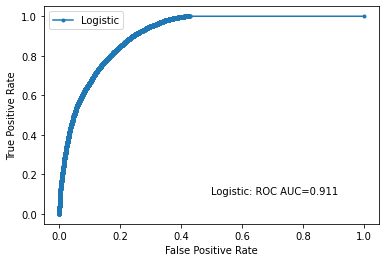

<IPython.core.display.Javascript object>

In [192]:
lr_probs = cv.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
fpr, tpr, _ = roc_curve(y_test.values, lr_probs)

lr_auc = roc_auc_score(y_test, lr_probs)
text = "Logistic: ROC AUC=%.3f" % (lr_auc)
x_pos = 0.5
y_pos = 0.1
plt.text(x_pos, y_pos, text)
# plot the roc curve for the model
plt.plot(fpr, tpr, marker=".", label="Logistic")
# axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# show the legend
plt.legend()
# show the plot
plt.show()

AUC is better, which means perform better across different threshold values

In [961]:
cv.best_params_

{'clf__criterion': 'entropy',
 'clf__max_depth': 12,
 'clf__max_features': 10,
 'clf__n_estimators': 200}

In [193]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.81      0.84     19120
         1.0       0.77      0.83      0.80     14131

    accuracy                           0.82     33251
   macro avg       0.82      0.82      0.82     33251
weighted avg       0.82      0.82      0.82     33251



<IPython.core.display.Javascript object>

Better performance after hyperparameter tuning using GridSearch